Notebook for figure 6 which analyzes data from the CIFAR runs and a small subsample of these images. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow.keras.backend as be

In [2]:
from utils import *
from data import *
from layers import *
from models import *

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
limit_gpus()
set_gpu(0)

In [5]:
dataset = "cifar10"
ds_train, ds_test, ds_info = load_dataset(dataset, 128)

input_shape = ds_info.features['image'].shape
num_classes = ds_info.features['label'].num_classes

In [7]:
dpi = 100

In [8]:
m_repeats = 15
m_time = 20.0

In [9]:
model = Conv2DPhasorModel(input_shape, projection="dot", onehot_offset=0.0, 
                    onehot_phase=0.5,n_hidden=1000, dropout_rate=0.20,
                         repeats=m_repeats,
                         exec_time=m_time,
                         max_step=0.05)

In [10]:
#np.savez_compressed("models/cifar_projection.npz", a=model.direction)

In [11]:
(xs, ys) = next(iter(ds_train))

In [12]:
x_train, y_train = get_raw_dat(ds_train)

In [13]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)

In [14]:
model(xs)

<tf.Tensor: shape=(128, 10), dtype=float32, numpy=
array([[-0.64000887, -0.3305788 , -0.21816899, ..., -0.11684592,
         0.11822535,  0.93058264],
       [ 0.34178925, -0.650519  ,  0.3199284 , ..., -0.02846527,
         0.02214676, -0.59783846],
       [-0.19075367, -0.5026063 ,  0.27185753, ...,  0.7293248 ,
         0.56938225,  0.9161014 ],
       ...,
       [-0.37696785, -0.48739937,  0.03682433, ..., -0.85773265,
        -0.58967876, -0.4970878 ],
       [-0.50771666, -0.45735428,  0.01081095, ..., -0.17847906,
         0.6167797 ,  0.84646606],
       [-0.35862696, -0.42972013,  0.2019646 , ..., -0.47077563,
        -0.58667946, -0.7901931 ]], dtype=float32)>

In [15]:
model.compile(optimizer="rmsprop")

In [16]:
model.dyn_params

{'leakage': -0.2,
 'period': 1.0,
 'window': 0.05,
 'spk_mode': 'gradient',
 'threshold': 0.03,
 'exec_time': 20.0,
 'max_step': 0.05}

In [17]:
model.load_weights("models/cifar1.wg")
model.direction = tf.constant(np.load("models/cifar_projection.npz")["a"])

In [18]:
model.accuracy(ds_test, False)

(<tf.Tensor: shape=(), dtype=float64, numpy=0.702>,)

In [19]:
xsp = model.project_fn(xs)

In [20]:
xsin = model.batchnorm(xsp)

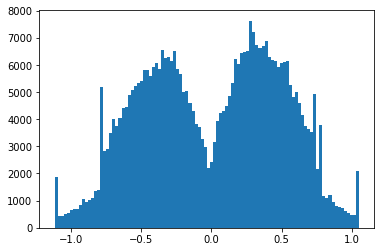

In [21]:
plt.hist(xsin.numpy().ravel(), bins=100 );

In [22]:
n_subsample = 32

In [23]:
xsin = xsin[0:n_subsample,...]

# static - go layer by layer

In [24]:
sc1 = model.conv1(xsin)
sc2 = model.conv2(sc1)
sp1 = model.pool1(sc2)
sd1 = model.dropout1(sp1)
sc3 = model.conv3(sd1)
sc4 = model.conv4(sc3)
sp2 = model.pool2(sc4)
sd2 = model.dropout2(sp2)
sfl = model.flatten(sd2)
sds1 = model.dense1(sfl)
sd3 = model.dropout3(sds1)
sds2 = model.dense2(sd3)

In [25]:
yh_static = model.predict(sds2, "static")

In [26]:
corr32s = (ys[0:n_subsample] == yh_static).numpy()

In [27]:
stata32 = tf.reduce_mean(tf.cast(ys[0:n_subsample] == yh_static, "float")).numpy()

# Dynamic - layer by layer

In [28]:
p2t = lambda x: phase_to_train(x, input_shape, repeats=m_repeats)

In [29]:
ssin = p2t(xsin)

In [ ]:
spks0 = model.conv1.call_dynamic(ssin, save_solutions = False)

 16%|█▌        | 5/32 [03:06<16:40, 37.06s/it]

In [34]:
phase0 = train_to_phase(spks0, model.conv1.output_shape2, depth=1, repeats=m_repeats+5)

In [35]:
fcast = lambda x: tf.cast(x, "float")

In [36]:
mse = lambda x, y: np.nanmean(np.power(fcast(x)-fcast(y),2))

In [43]:
def nan_mse(x, y):
    x = x.numpy()
    y = y.numpy()
    
    nans = np.isnan(x)
    diffs = x - y
    diffs[nans] = 1.0
    return np.mean(np.power(diffs, 2.0))

In [44]:
nan_mse(phase0[0][0,...], sc1[0])

0.6920885097815971

In [45]:
phase0[0].shape

TensorShape([20, 30, 30, 32])

In [46]:
nans1 = np.array([[np.sum(np.isnan(phase0[j][i,...])) for i in range(20)] for j in range(32)])

In [47]:
mse1s = np.array([[nan_mse(phase0[j][i,...], sc1[j]) for i in range(20)] for j in range(32)])

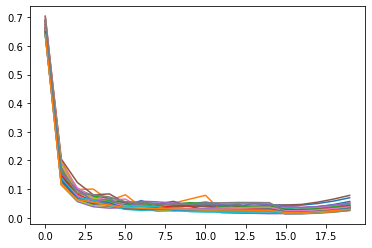

In [48]:
plt.plot(mse1s.transpose());

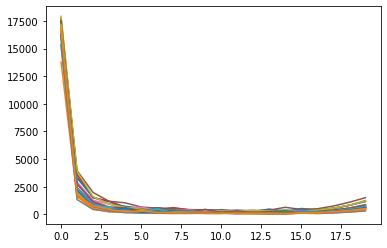

In [49]:
plt.plot(nans1.transpose());

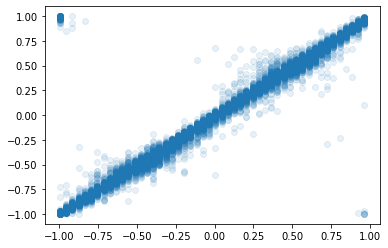

In [50]:
plt.scatter(phase0[0][-1,...], sc1[0,...], alpha=0.1)

In [51]:
spks1 = model.conv2.call_dynamic(spks0)

100%|██████████| 32/32 [22:00<00:00, 41.28s/it]


In [52]:
phase1 = train_to_phase(spks1, model.conv2.output_shape2, depth=2, repeats=m_repeats+5)

In [53]:
mse2s = np.array([[nan_mse(phase1[j][i,...], sc2[j]) for i in range(20)] for j in range(32)])

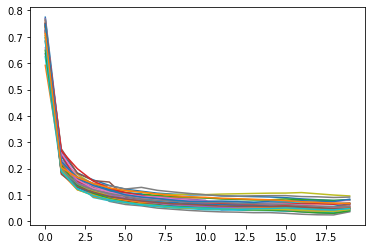

In [54]:
plt.plot(mse2s.transpose());

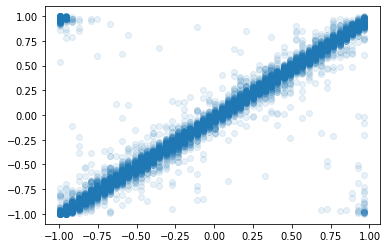

In [55]:
plt.scatter(phase1[0][-1,...], sc2[0,...], alpha=0.1)

In [56]:
poolin = model.conv2.output_shape2

In [57]:
poolout = model.pool_layer1.compute_output_shape([None, *poolin])[1:]

In [58]:
poolout

TensorShape([14, 14, 32])

In [59]:
spks2 = dynamic_minpool2D(spks1, poolin, (2,2), period=1.0, depth=2)

In [87]:
phase2 = train_to_phase(spks2, poolout, depth=2, repeats=m_repeats+5)

In [96]:
mse3s = np.array([[nan_mse(phase2[j][i,...], sp1[j]) for i in range(20)] for j in range(32)])

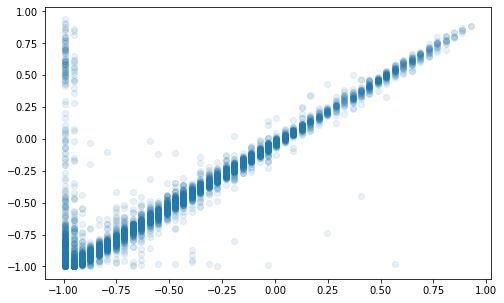

In [61]:
plt.figure(figsize=(8,5))
plt.scatter(phase2[0][-1,...], sp1[0,...], alpha=0.1)

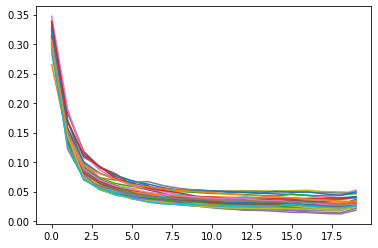

In [93]:
plt.plot(mse3s.transpose());

Text(0.5, 0, 'Time (s)')

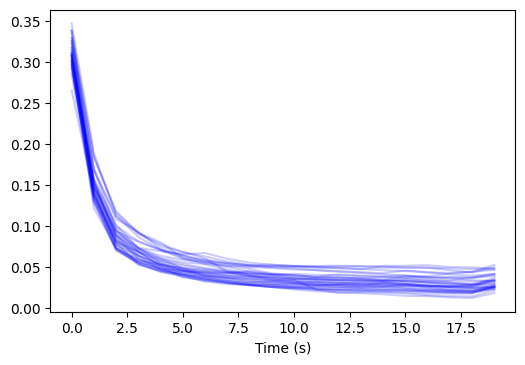

In [148]:
plt.figure(dpi=dpi)
plt.plot(mse3s.transpose(), label="Min. Pool 1", color="blue", alpha=0.20);
plt.xlabel("Time (s)")

In [62]:
spks3 = model.conv3.call_dynamic(spks2)

100%|██████████| 32/32 [12:23<00:00, 23.23s/it]


In [94]:
phase3 = train_to_phase(spks3, model.conv3.output_shape2, depth=3, repeats=m_repeats+5)

In [97]:
mse4s = np.array([[nan_mse(phase3[j][i,...], sc3[j]) for i in range(20)] for j in range(32)])

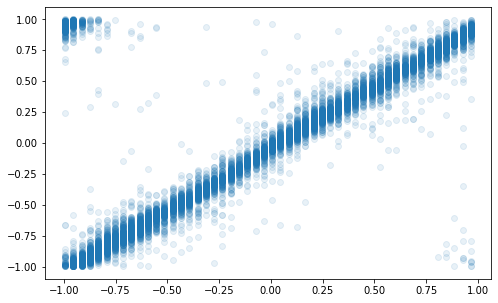

In [64]:
plt.figure(figsize=(8,5))
plt.scatter(phase3[0][-1,...], sc3[0,...], alpha=0.1)

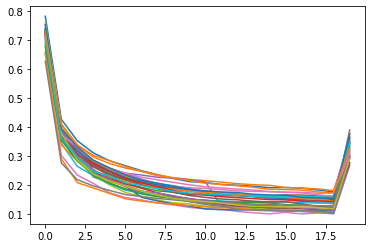

In [98]:
plt.plot(mse4s.transpose());

In [65]:
spks4 = model.conv4.call_dynamic(spks3)

100%|██████████| 32/32 [13:30<00:00, 25.34s/it]


In [99]:
phase4 = train_to_phase(spks4, model.conv4.output_shape2, depth=4, repeats=m_repeats+5)

In [100]:
mse5s = np.array([[nan_mse(phase4[j][i,...], sc4[j]) for i in range(20)] for j in range(32)])

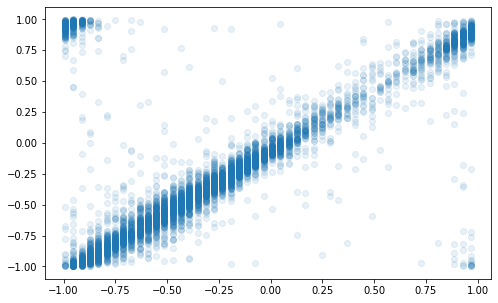

In [103]:
plt.figure(figsize=(8,5))
plt.scatter(phase4[0][-2,...], sc4[0,...], alpha=0.1)

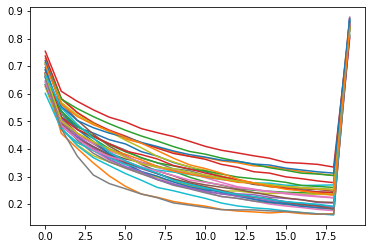

In [101]:
plt.plot(mse5s.transpose());

In [68]:
poolin2 = model.conv4.output_shape2

In [69]:
poolout2 = model.pool_layer2.compute_output_shape([None, *poolin2])[1:]

In [70]:
spks5 = dynamic_minpool2D(spks4, poolin2, (2,2), period=1.0, depth=4)

In [104]:
phase5 = train_to_phase(spks5, poolout2, depth=4, repeats=m_repeats+5)

In [105]:
mse6s = np.array([[nan_mse(phase5[j][i,...], sp2[j]) for i in range(20)] for j in range(32)])

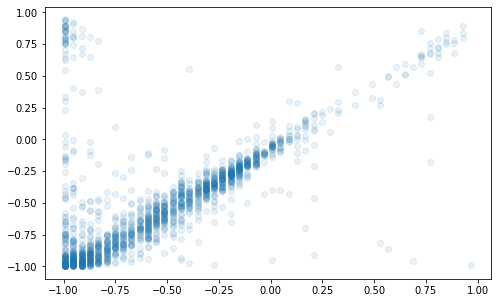

In [72]:
plt.figure(figsize=(8,5))
plt.scatter(phase5[0][-1,...], sp2[0,...], alpha=0.1)

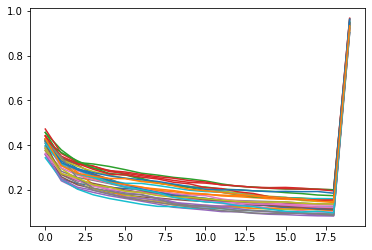

In [106]:
plt.plot(mse6s.transpose());

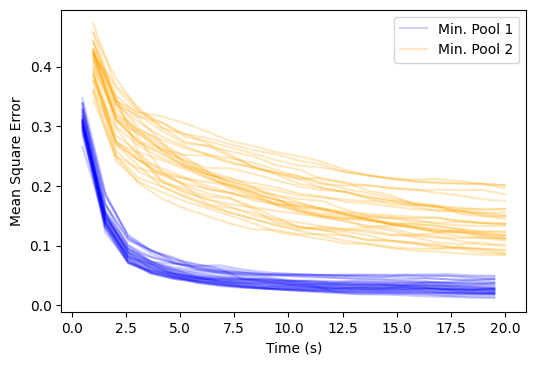

In [163]:
plt.figure(dpi=dpi)
plt.plot(0.5+np.linspace(0, 19, 19), mse3s[0:1,0:19].transpose(), label="Min. Pool 1", color="blue", alpha=0.20);
plt.plot(0.5+np.linspace(0, 19, 19), mse3s[1:,0:19].transpose(), color="blue", alpha=0.20);

plt.plot(1.0+np.linspace(0, 19, 19), mse6s[0:1,0:19].transpose(), label="Min. Pool 2", color="orange", alpha=0.25);
plt.plot(1.0+np.linspace(0, 19, 19), mse6s[1:,0:19].transpose(), color="orange", alpha=0.25);

plt.xlabel("Time (s)")
plt.ylabel("Mean Square Error")
plt.legend()

In [73]:
# def dynamic_flatten(trains, input_shape):
    
#     def flatten_lambda(x):
#         indices, times = x
#         flat_indices = ravel_index(indices, input_shape)
        
#         return (flat_indices, times)

#     return list(map(flatten_lambda, trains))

In [74]:
spks_flt = dynamic_flatten(spks5, input_shape=poolout2)

In [75]:
spks6 = model.dense1.call_dynamic(spks_flt)

100%|██████████| 32/32 [06:21<00:00, 11.93s/it]


In [107]:
phase6 = train_to_phase(spks6, model.dense1.output_shape2, depth=5, repeats=m_repeats+5)

In [108]:
mse7s = np.array([[nan_mse(phase6[j][i,...], sds1[j]) for i in range(20)] for j in range(32)])

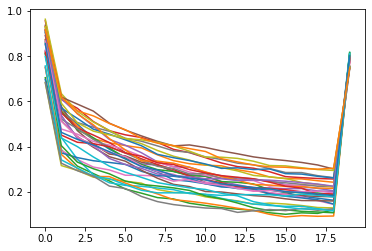

In [109]:
plt.plot(mse7s.transpose());

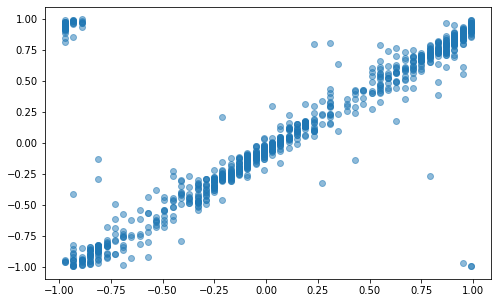

In [111]:
plt.figure(figsize=(8,5))
plt.scatter(phase6[0][-2,:], sds1[0], alpha=0.5)

In [78]:
model.dense2.input_shape2 = tf.constant([1000], dtype="int64")

In [79]:
spks7 = model.dense2.call_dynamic(spks6)

100%|██████████| 32/32 [04:42<00:00,  8.83s/it]


In [112]:
phase7 = train_to_phase(spks7, model.dense2.output_shape2, depth=6, repeats=m_repeats+5)

In [113]:
mse8s = np.array([[nan_mse(phase7[j][i,...], sds2[j]) for i in range(20)] for j in range(32)])

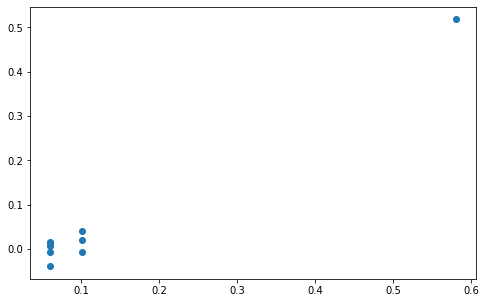

In [81]:
plt.figure(figsize=(8,5))
plt.scatter(phase7[0][-1,:], sds2[0])

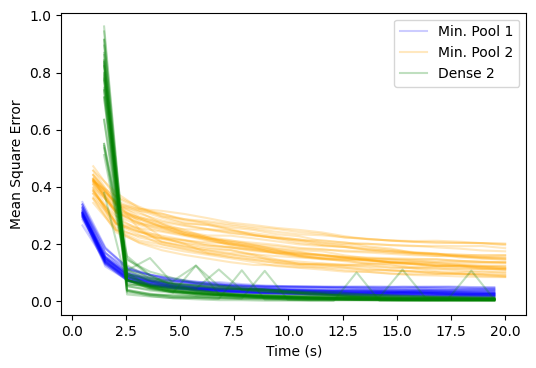

In [168]:
plt.figure(dpi=dpi)
plt.plot(0.5+np.linspace(0, 19, 19), mse3s[0:1,0:19].transpose(), label="Min. Pool 1", color="blue", alpha=0.20);
plt.plot(0.5+np.linspace(0, 19, 19), mse3s[1:,0:19].transpose(), color="blue", alpha=0.20);

plt.plot(1.0+np.linspace(0, 19, 19), mse6s[0:1,0:19].transpose(), label="Min. Pool 2", color="orange", alpha=0.25);
plt.plot(1.0+np.linspace(0, 19, 19), mse6s[1:,0:19].transpose(), color="orange", alpha=0.25);

plt.plot(1.5+np.linspace(0, 18, 18), mse8s[0:1,0:18].transpose(), label="Dense 2", color="green", alpha=0.25);
plt.plot(1.5+np.linspace(0, 18, 18), mse8s[1:,0:18].transpose(), color="green", alpha=0.25);

plt.xlabel("Time (s)")
plt.ylabel("Mean Square Error")
plt.legend()

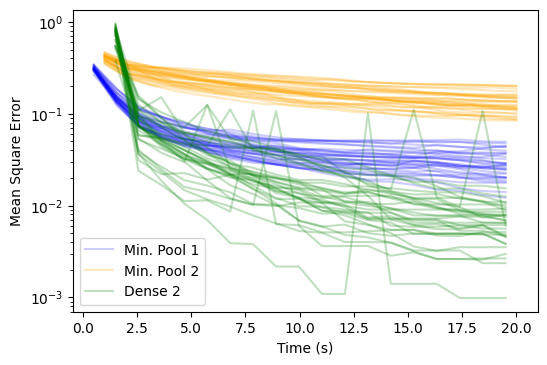

In [169]:
plt.figure(dpi=dpi)
plt.semilogy(0.5+np.linspace(0, 19, 19), mse3s[0:1,0:19].transpose(), label="Min. Pool 1", color="blue", alpha=0.20);
plt.semilogy(0.5+np.linspace(0, 19, 19), mse3s[1:,0:19].transpose(), color="blue", alpha=0.20);

plt.semilogy(1.0+np.linspace(0, 19, 19), mse6s[0:1,0:19].transpose(), label="Min. Pool 2", color="orange", alpha=0.25);
plt.semilogy(1.0+np.linspace(0, 19, 19), mse6s[1:,0:19].transpose(), color="orange", alpha=0.25);

plt.plot(1.5+np.linspace(0, 18, 18), mse8s[0:1,0:18].transpose(), label="Dense 2", color="green", alpha=0.25);
plt.plot(1.5+np.linspace(0, 18, 18), mse8s[1:,0:18].transpose(), color="green", alpha=0.25);

plt.xlabel("Time (s)")
plt.ylabel("Mean Square Error")
plt.legend()

In [179]:
trange = np.linspace(0.0, 20.0, 501)

In [193]:
cspks2 = [np.mean([np.sum(spks2[j][1] < t)) for j in range(32)]) for t in trange]

In [191]:
cspks5 = [np.mean([np.sum(spks5[j][1] < t) for j in range(32)]) for t in trange]

In [199]:
cspks7 = [np.mean([np.sum(spks7[j][1] < t) for j in range(32)]) for t in trange]

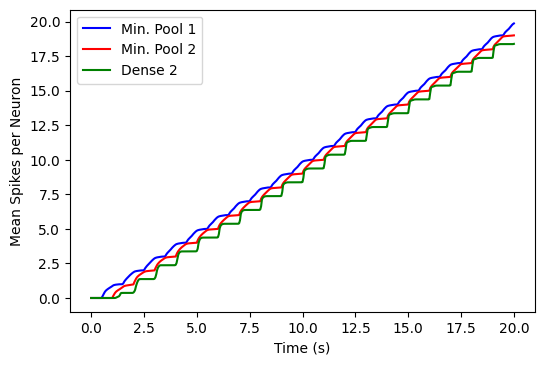

In [203]:
plt.figure(dpi=dpi)
plt.plot(trange,cspks2/np.prod((14,14,32)), label="Min. Pool 1", color="blue")
plt.plot(trange,cspks5/np.prod((5,5,64)), label="Min. Pool 2", color="red")
plt.plot(trange,cspks7/np.prod((10)), label="Dense 2", color="green")
plt.ylabel("Mean Spikes per Neuron")
plt.xlabel("Time (s)")
plt.legend()

In [182]:
spks5[0][1]

<tf.Tensor: shape=(30465,), dtype=float32, numpy=
array([ 2.0091968,  2.069197 ,  3.2064078, ..., 17.583773 , 18.583773 ,
       19.563126 ], dtype=float32)>

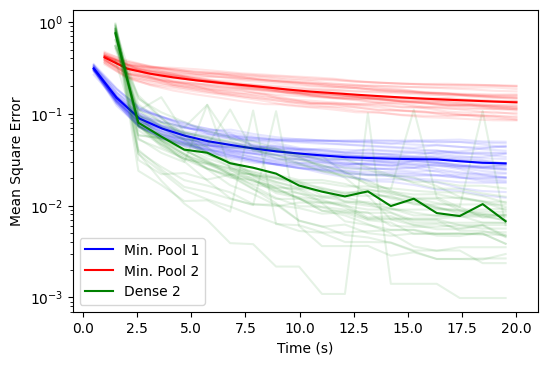

In [178]:
plt.figure(dpi=dpi)
plt.semilogy(0.5+np.linspace(0, 19, 19), np.mean(mse3s[:,0:19], axis=0).transpose(), label="Min. Pool 1", color="blue");
plt.semilogy(0.5+np.linspace(0, 19, 19), mse3s[:,0:19].transpose(), color="blue", alpha=0.10);

plt.semilogy(1.0+np.linspace(0, 19, 19), np.mean(mse6s[:,0:19], axis=0).transpose(), label="Min. Pool 2", color="red");
plt.semilogy(1.0+np.linspace(0, 19, 19), mse6s[:,0:19].transpose(), color="red", alpha=0.10);

plt.plot(1.5+np.linspace(0, 18, 18), np.mean(mse8s[:,0:18], axis=0).transpose(), label="Dense 2", color="green");
plt.plot(1.5+np.linspace(0, 18, 18), mse8s[:,0:18].transpose(), color="green", alpha=0.10);

plt.xlabel("Time (s)")
plt.ylabel("Mean Square Error")
plt.legend()

In [216]:
all_predictions = np.load("1024_dyn.npz")["a"]

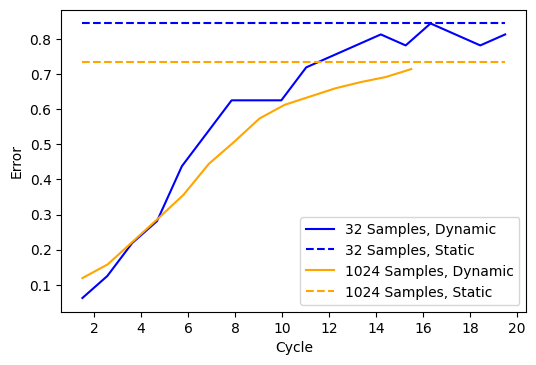

In [264]:
plt.figure(dpi=dpi)
plt.plot(1.5+np.linspace(0, 18 , 18), t_acc[0:18], label="32 Samples, Dynamic", color="blue")
plt.plot(1.5+np.linspace(0, 18 , 18), np.ones(18)*stata32, "--", label="32 Samples, Static", color="blue")
plt.plot(1.5+np.linspace(0, 14 , 14), all_predictions[0:14], label="1024 Samples, Dynamic",  color="orange")
plt.plot(1.5+np.linspace(0, 18 , 18), np.ones(18)*0.7353515625, "--", label="1024 Samples, Static", color="orange")
plt.xticks(np.arange(2,21,2), np.arange(2,21,2))
plt.xlabel("Cycle")
plt.ylabel("Error")
plt.legend()

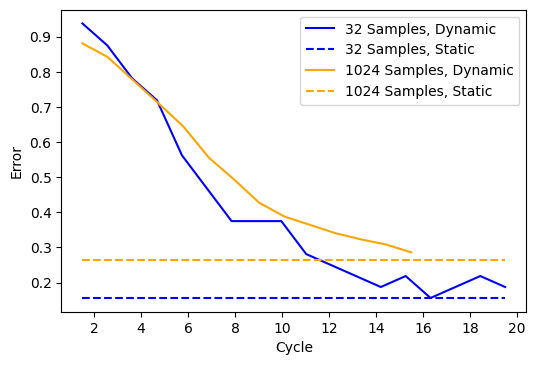

In [263]:
plt.figure(dpi=dpi)
plt.plot(1.5+np.linspace(0, 18 , 18), np.ones(18) - t_acc[0:18], label="32 Samples, Dynamic", color="blue")
plt.plot(1.5+np.linspace(0, 18 , 18), 1.0 - np.ones(18)*stata32, "--", label="32 Samples, Static", color="blue")
plt.plot(1.5+np.linspace(0, 14 , 14), np.ones(14) - all_predictions[0:14], label="1024 Samples, Dynamic",  color="orange")
plt.plot(1.5+np.linspace(0, 18 , 18), 1.0 - np.ones(18)*0.7353515625, "--", label="1024 Samples, Static", color="orange")
plt.xticks(np.arange(2,21,2), np.arange(2,21,2))
plt.xlabel("Cycle")
plt.ylabel("Error")
plt.legend()

In [121]:
p7ss = tf.stack(phase7, axis=0)

In [125]:
dyn_predictions = tf.stack([model._predict_ind(p7ss, j) for j in range(20)], axis=0)

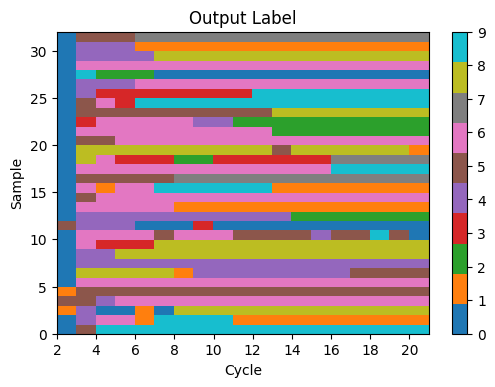

In [215]:
plt.figure(dpi=dpi)
plt.pcolor(dyn_predictions[0:19,:].numpy().transpose(), cmap="tab10")
plt.xticks(np.arange(0,19,2), np.arange(2,21,2))
plt.xlabel("Cycle")
plt.ylabel("Sample")
plt.title("Output Label")
plt.colorbar()

In [242]:
corr32s

array([ True,  True,  True,  True,  True,  True, False, False,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True])

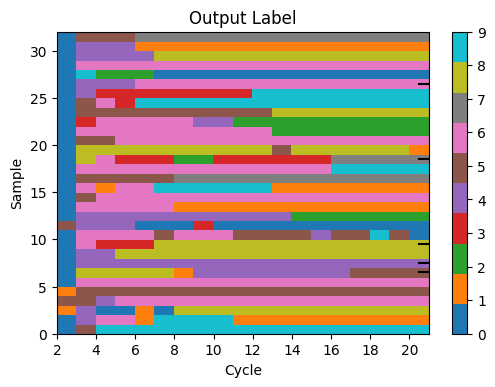

In [248]:
plt.figure(dpi=dpi)
plt.pcolor(dyn_predictions[0:19,:].numpy().transpose(), cmap="tab10")
plt.xticks(np.arange(0,19,2), np.arange(2,21,2))
for i in range(32):
    if not corr32s[i]:
        plt.plot((18.5,19.0), (i+0.5, i+0.5),"black")
plt.xlabel("Cycle")
plt.ylabel("Sample")
plt.title("Output Label")
plt.colorbar()

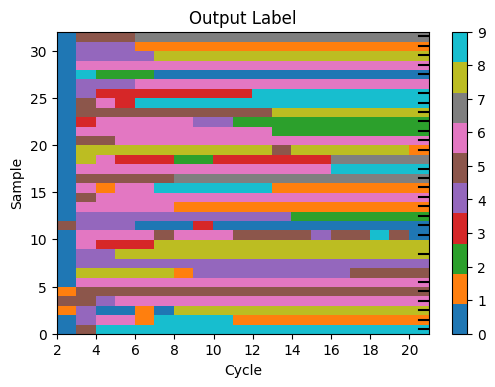

In [249]:
plt.figure(dpi=dpi)
plt.pcolor(dyn_predictions[0:19,:].numpy().transpose(), cmap="tab10")
plt.xticks(np.arange(0,19,2), np.arange(2,21,2))
for i in range(32):
    if corr32s[i]:
        plt.plot((18.5,19.0), (i+0.5, i+0.5),"black")
plt.xlabel("Cycle")
plt.ylabel("Sample")
plt.title("Output Label")
plt.colorbar()

In [136]:
dyn_predictions.shape

TensorShape([20, 32])

In [135]:
yss = ys[0:32]

In [252]:
dyn_right = np.array([yss.numpy() == dyn_predictions[i,:].numpy() for i in range(20)])

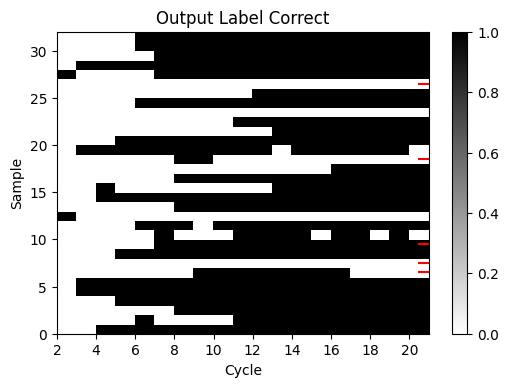

In [259]:
plt.figure(dpi=dpi)
plt.pcolor(dyn_right[0:19,:].transpose(), cmap="binary")
plt.xticks(np.arange(0,19,2), np.arange(2,21,2))
for i in range(32):
    if not corr32s[i]:
        plt.plot((18.5,19.0), (i+0.5, i+0.5),"red")
plt.xlabel("Cycle")
plt.ylabel("Sample")
plt.title("Output Label Correct")
plt.colorbar()

In [138]:
t_acc = [np.mean(yss.numpy() == dyn_predictions[i,:].numpy()) for i in range(20)]

In [141]:
n_correct = [np.sum(yss.numpy() == dyn_predictions[i,:].numpy()) for i in range(20)]

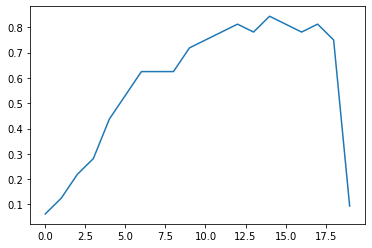

In [139]:
plt.plot(t_acc)

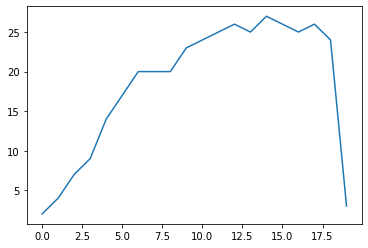

In [142]:
plt.plot(n_correct)

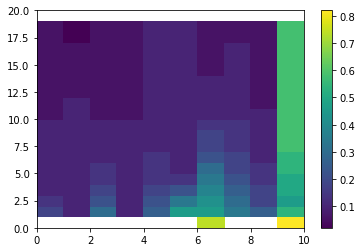

In [129]:
plt.pcolor(phase7[0])
plt.colorbar()

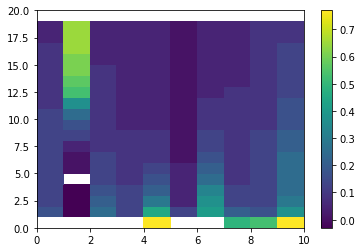

In [130]:
plt.pcolor(phase7[1])
plt.colorbar()

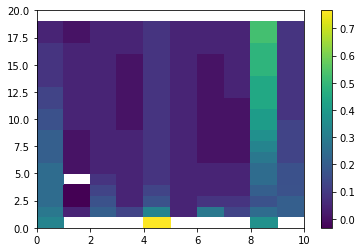

In [131]:
plt.pcolor(phase7[2])
plt.colorbar()

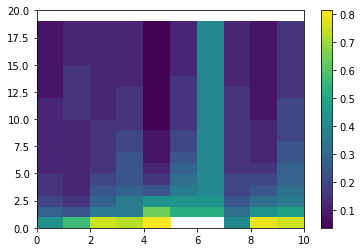

In [132]:
plt.pcolor(phase7[3])
plt.colorbar()